# Entity extraction
Partendo da collection raw, estraggo alcuni tipi di entità (nomi, aggettivi, ecc) e metto in rumors_entity, che ha stessi elementi in aggiunta un campo "entities"

In [1]:
import pymongo
client=pymongo.MongoClient()#senza parametri si connette a localhost.

client.list_database_names()

db=client['inforet']#prendo il db, se non c'è lo crea

col = db['rumors_raw']

tweets = []
for record in col.find():
    tweets.append(record)

### Estrazione entità e tagging con CMU Tagger

In [2]:
import nbimporter
from TweetParser.TweetParser import TweetParser #http://www.cs.cmu.edu/~ark/TweetNLP/

parser = TweetParser() # oppure parser = TweetParser(tags_to_keep) #tags_to_keep = [ 'N','^','S','Z','A','#','$'] #print parser.tags_to_keep
#tagged_entities = parser.tokenize_tweets_from_file("TweetParser/examples/example_tweets.txt")
entities = parser.tokenize_tweets(tweets)
print "Parsed: " + str(len(entities))

Importing Jupyter notebook from TweetParser\TweetParser.ipynb
Parsed: 8560


### Aggiunta al db

In [4]:
for i in range(len(tweets)):
    tweets[i]['entities']= entities[i]

In [5]:
client=pymongo.MongoClient()
db=client['inforet']
db["rumors_entity_cmu"].drop()
col = db["rumors_entity_cmu"]
col.insert_many(tweets)

### Filtraggio per tipo

In [6]:
list_of_types = [ 'N','^','S','Z','A','#','$']

def keep_only_entities_of_type(entities, list_of_types):
    for index, l in enumerate(entities):
        filtered_list = [entity_tag for entity_tag in l if entity_tag[1] in list_of_types]
        entities[index] = filtered_list
    return entities

### Rimozione stopwords

In [7]:
from nltk.corpus import stopwords

def remove_stopwords(entities, list_of_stopwords=[]):
    
    if not list_of_stopwords:
        list_of_stopwords = set(stopwords.words('english'))
    
    for index, l in enumerate(entities):
        filtered_list = [entity_tag for entity_tag in l if entity_tag[0].lower() not in list_of_stopwords]
        entities[index] = filtered_list
    return entities

#### Remove confidence

In [8]:
def remove_confidence(entities):
    for index, l in enumerate(entities):
        filtered_list = [ (entity_tag[0],entity_tag[1]) for entity_tag in l]
        entities[index] = filtered_list
    return entities

#### lowercase

In [9]:
def entities_to_lower(entities):
    for list_index, list_entities_in_tweet in enumerate(entities):
        for index_entity, entity_tag in enumerate(list_entities_in_tweet):
            entities[list_index][index_entity] = (entity_tag[0].lower(),entity_tag[1],entity_tag[2])
    return entities

In [10]:
#entities_to_lower(entities)
#print len(set([tag[0] for e in entities for tag in e ]))

### Pre-processing pipeline

#### Tags to keep

tags_to_keep= [ 'N','^','Z','A','#','$','S'] 

sono quelle più legate alla parte nominale
 
dubbie V verbi U url R avverbi. 

Decise:  @ at E esclamazioni G garbage/foreign words ! interiezioni

In [11]:
#UNIQUEEE
u= dict()
for t in parser.tags_meaning.keys():
    n = len(set([tag[0] for e in entities for tag in e if tag[1] == t]))
    u[t]=n
print u

{'!': 276, '#': 598, '$': 277, '&': 24, ',': 119, 'A': 1204, '@': 1895, 'E': 40, 'D': 98, 'G': 460, 'M': 0, 'L': 107, 'O': 105, 'N': 4015, 'P': 217, 'S': 20, 'R': 408, 'U': 3183, 'T': 14, 'V': 2371, 'Y': 0, 'X': 7, 'Z': 108, '^': 2754, '~': 35}


In [12]:
from prettytable import PrettyTable
from collections import Counter

c = Counter([tag[1] for e in entities for tag in e ]).most_common()

x = PrettyTable()

x.field_names = ["Type","Total","Unique","Rate","Meaning"]

meanings = parser.tags_meaning

#UNIQUEEE
u= dict()
for t in parser.tags_meaning.keys():
    n = len(set([tag[0] for e in entities for tag in e if tag[1] == t]))
    u[t]=n
#print u

from nltk.corpus import stopwords
list_of_stopwords = set(stopwords.words('english'))

stopw= dict()
for t in parser.tags_meaning.keys():
    n = len(set([tag[0] for e in entities for tag in e if tag[1] == t and tag[0] in list_of_stopwords ]))
    stopw[t]=n

for v in c:
    v = list(v)
    #print meanings[v[0]]
    v.append(u[v[0]])
    v.append(float(u[v[0]])*100/v[1])
    #v.append(stopw[v[0]])
    v.append(meanings[v[0]])
    
    #print v
    x.add_row(v)



x.align["Meaning"] = "l"
x.align["Total"] = "r"
x.align["Unique"] = "r"
x.align["Rate"] = "r"
#x.align["Stopwords"] = "r"
print(x)

+------+-------+--------+----------------+-----------------------------------------------------------------------------------+
| Type | Total | Unique |           Rate | Meaning                                                                           |
+------+-------+--------+----------------+-----------------------------------------------------------------------------------+
|  N   | 26850 |   4015 |  14.9534450652 | common noun                                                                       |
|  ^   | 24122 |   2754 |  11.4169637675 | proper noun                                                                       |
|  V   | 21279 |   2371 |  11.1424409042 | verb incl. copula, auxiliaries                                                    |
|  ,   | 20951 |    119 |  0.56799198129 | punctuation                                                                       |
|  P   | 15524 |    217 |  1.39783560938 | pre- or postposition, or subordinating conjunction                  

In [13]:
tags_to_keep= [ 'N','^','S','Z','A','#','$']

#### Pipeline Execution

In [14]:
import pymongo
import nbimporter
from TweetParser.TweetParser import TweetParser #http://www.cs.cmu.edu/~ark/TweetNLP/

client=pymongo.MongoClient()#senza parametri si connette a localhost.

db=client['inforet']#prendo il db, se non c'è lo crea

col = db['rumors_entity_cmu']

### RETRIEVAL
p = []
p.append({'$match':{'languages':'en'}})

#selection = {}
selection = {'rumor': { '$in': ['michelle','airfrance','palin']}}
#selection ={'rumor': { '$in': ['michelle','airfrance']}}
print selection
p.append({'$match': selection})

tweets = []
entities = []
for record in col.aggregate(p): # col.find(selection):
    tweets.append(record)
    entities.append(record['entities'])

print "Retrieved " + str(len(entities)) + " tweets"

remove_stopwords(entities)
keep_only_entities_of_type(entities,[ 'N','^','S','Z','A','#','$'])

### INSERT IN DB AS NEW COLLECTION
for i in range(len(tweets)):
    tweets[i]['entities'] = entities[i]
db["rumors_entity_cmu_filtered"].drop()
col = db["rumors_entity_cmu_filtered"]
col.insert_many(tweets)

{'rumor': {'$in': ['michelle', 'airfrance', 'palin']}}
Retrieved 4751 tweets


### Tracker

In [1]:
import nbimporter
from Tracker import Tracker

Importing Jupyter notebook from Tracker.ipynb


## Cluster

In [2]:
import nbimporter
from Tracker import Cluster

In [3]:
jd = Tracker('inforet','rumors_entity_cmu_filtered',decay_window=24, decay_factor_T=1.0/25000, similarity_threshold= 0.3)

In [4]:
print jd.window_size
print jd.update_for_first_k
print jd.update_for_every_n
print jd.hashtag_boost
print jd.decay_window
print jd.decay_factor_T
print jd.keep_top_perc
#print jd.icfs
print jd.clusters

60
200
10
1.5
24
4e-05
95
[]


In [5]:
import datetime

a = datetime.datetime.now()
print "start ", a

jd.clusterize(use_decay=True)
b = datetime.datetime.now()

print "end ", b
print "delta", b-a

start  2018-10-07 19:17:30.891000


Tracker.ipynb:81: RuntimeWarning: invalid value encountered in divide
  "                        # se non faccio aggiunte da molto tempo,\n",


end  2018-10-07 19:18:12.609000
delta 0:00:41.718000


In [6]:
print len(jd.clusters)
print len(jd.discarded)

442
0


In [7]:
cl = jd.clusters[2]
cl.M.shape

(9L, 1L)

# Analisi Risultati

In [8]:
cl_lens = [len(c.tweets) for c in jd.clusters]
import numpy as np
print np.mean(cl_lens)
print np.max(cl_lens)
print np.min(cl_lens)
print np.percentile(cl_lens,75)
print np.median(cl_lens)
#print np.var(cl_lens)

10.748868778280542
304
1
5.0
1.0


 ### Clusters size


In [9]:
degree_sample = cl_lens

In [10]:
# np.arange(min_t,max_t+1) #Perchè +1? perchè vengono generati valori fino a max_t, max t escluso
# +2 perchè altrimenti unisce gli ultimi due intervalli
count_people, bins_people = np.histogram(degree_sample,np.arange(np.min(degree_sample),np.max(degree_sample)+2))

pdf_people = count_people/float(len(degree_sample))
#print pdf_people
sum(pdf_people)

0.9999999999999992

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'PDF')

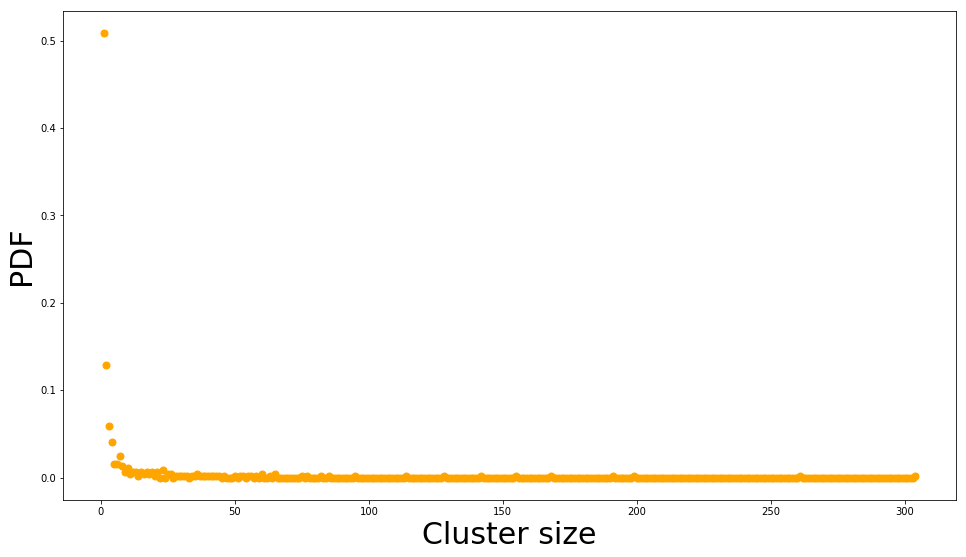

In [12]:
fig = plt.figure(figsize=(16,9)) #è la dimensione del grafico
assi = fig.gca()
assi.plot(bins_people[:-1],pdf_people,color='orange',marker='o',linestyle='None', ms = 7)
assi.set_xlabel('Cluster size',size=30)
assi.set_ylabel('PDF',size=30)
#fig.savefig('pdf.png', dpi=300)

Text(0,0.5,'CDF')

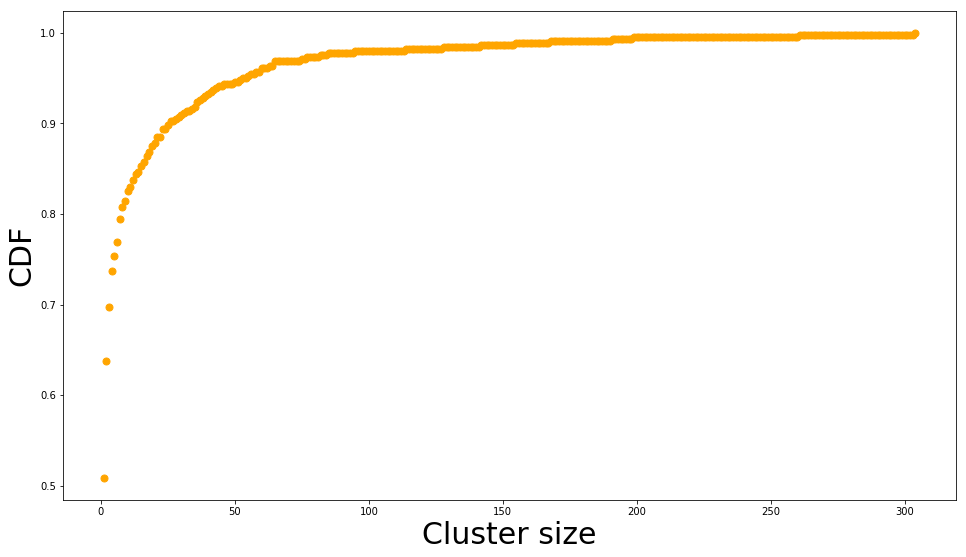

In [13]:
cdf_people = np.cumsum(pdf_people)
fig = plt.figure(figsize=(16,9))
assi = fig.gca()
assi.plot(bins_people[:-1],cdf_people,color='orange',marker='o',linestyle='None', ms = 7)#linestyle='--'
assi.set_xlabel('Cluster size',size=30)
assi.set_ylabel('CDF',size=30)
#fig.savefig('cdf.png', dpi=300)

In [14]:
x = [cl for cl in jd.clusters if len(cl.tweets) >= 10]
y = [cl for cl in jd.clusters if len(cl.tweets) < 10]
print len(x)
print len(y)

82
360


### Cluster vs rumors

In [15]:
from collections import Counter
perc = {}
clusters_over_100 =  [(i,cl) for i,cl in enumerate(jd.clusters) if len(cl.tweets) >= 30]
#print a[0]
for el in clusters_over_100:
    i = el[0]
    cl = el[1]
    c = Counter()
    for t in cl.tweets:
        c.update({t['rumor']:1})
    perc[i] = c

https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html

obama
michelle
airfrance
palin
cell


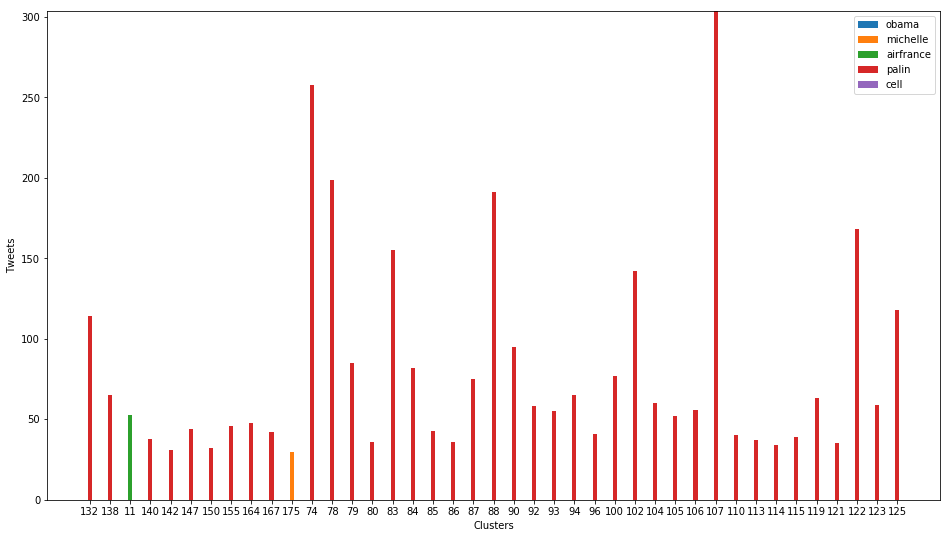

In [18]:
import numpy as np
import matplotlib.pyplot as plt

cluster_numbers = { }
rumors=['obama' , 'michelle' ,'airfrance','palin','cell']

previous = np.array(len(perc.keys()))
previous = [0 for x in perc.keys()]
#previous = [0,0,0,0,0,0,0]
plots = []
ind = np.arange(len(perc.keys()))
width = 0.2 #len(perc.keys()) # the width of the bars: can also be len(x) sequence

fig = plt.figure(figsize=(16,9)) #è la dimensione del grafico
assi = fig.gca()

for r in rumors:
    print r
    means = []
    for k in perc.keys():
        #print k
        #print r
        #print perc[k][r]
        means.append(perc[k][r])
        #print womenMeans
    #print womenMeans 
    p = assi.bar(ind, means, width, bottom=previous)
    previous = means
    plots.append((p,r))

plt.ylabel('Tweets')
#plt.title('Scores by group and gender')
plt.xticks(ind, perc.keys())
plt.xlabel('Clusters')
#plt.yticks(np.arange(0, 81, 10))
plt.legend([x[0] for x in plots], [x[1] for x in plots])
plt.show()

In [19]:
x = [cl for cl in jd.clusters if len(cl.tweets) >= 10]
y = [cl for cl in jd.clusters if len(cl.tweets) < 10]
print len(x)
print len(y)

82
360
